# Getting started with using LF Energy for load flow simulations
Before first go, these commands should be run to make sure the environment is set

In [ ]:
pip install uv

: 

I am using uv to handle dependecies etc. so commands are based on this.


In [59]:
#importing the libraries
import pypowsybl as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os #to save files to path
SAVE_DIR = "Saved_results"
os.makedirs(SAVE_DIR, exist_ok=True)

In [2]:
# code to create the network
def create_9_bus_network():
    n = pp.network.create_ieee9() #creating the network based on built in network template
    buses=n.get_buses()
    print(buses)
    
    generators=n.get_generators()
    print(generators)
    
    lines=n.get_lines()
    print(lines)
    
    transformers=n.get_2_windings_transformers()
    print(transformers)
    
    loads=n.get_loads()
    print(loads)
    return n

In [ ]:
#Standard way to simulate
# here we just use the built in default values for IEEE 9bus system and run an ordinary powerflow simulation....
n_base=create_9_bus_network()
results=pp.loadflow.run_ac(n_base)


      name  v_mag  v_angle  connected_component  synchronous_component  \
id                                                                       
VL1_0       104.0   0.0000                    0                      0   
VL1_1       102.5  -2.2160                    0                      0   
VL2_0       102.5   9.2800                    0                      0   
VL2_1       102.5   3.7197                    0                      0   
VL3_0       102.5   4.6647                    0                      0   
VL3_1       103.2   1.9667                    0                      0   
VL5_0        99.5  -3.9880                    0                      0   
VL6_0       101.2  -3.6870                    0                      0   
VL8_0       101.5   0.7275                    0                      0   

      voltage_level_id  
id                      
VL1_0              VL1  
VL1_1              VL1  
VL2_0              VL2  
VL2_1              VL2  
VL3_0              VL3  
VL3_1     

## Plotting results

### Topology


In [27]:
#We can plot the results in SLDs, where the arrows indicate direction and active(black) / reactive (blue) power flow. 
# SLDs can be printed for one voltage level (specified by 'VL1','VL2', 'VL3', 'VL5', 'VL6' or 'VL8' ). If SLD for non existing voltage level is tried this returs error ('VL4', 'VL7' or 'VL9')
n_base.get_single_line_diagram('VL1')

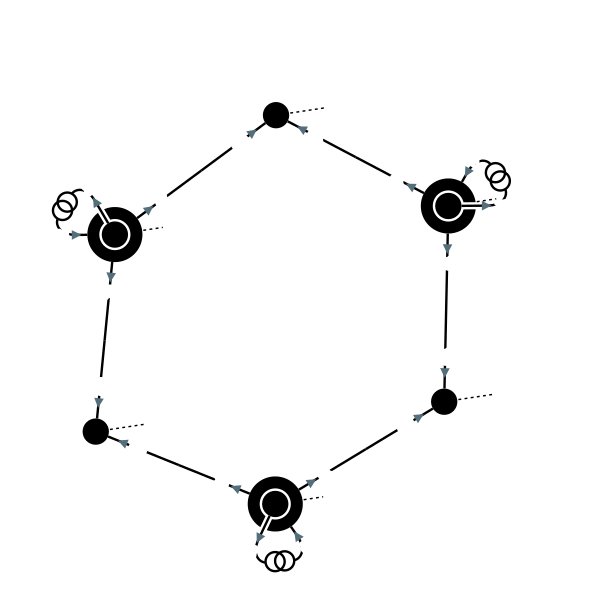

In [ ]:
# You can also get the entire network plotted with get_network_area_diagram(). Here the voltage level can be specified, an this returs similar plot, but only for the specified voltage level. 
n_base.get_network_area_diagram()

In [ ]:
# The plot can be saved to file as svg. 

path=os.path.join(SAVE_DIR,'ieee9_sld.svg') # using a specified folder to store the plots...
n_base.write_single_line_diagram_svg('VL1',path)

### Customizing the variables

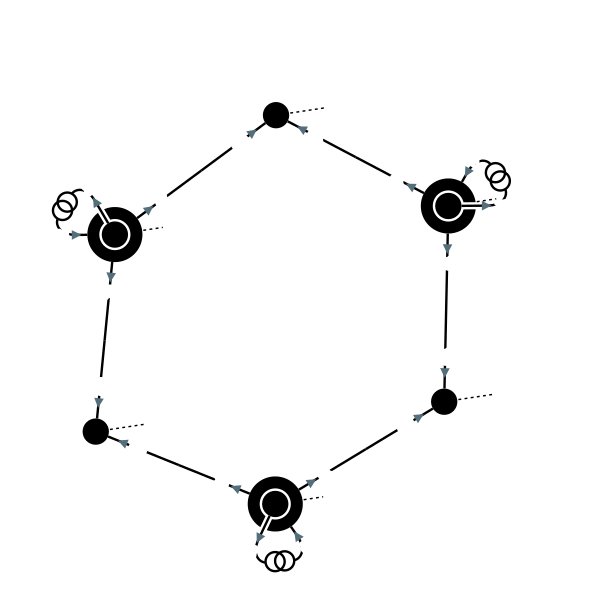

In [29]:
# We now compare the network results to eachother when changing some parameters...
# Load the standard IEEE 9-bus network

n2 = pp.network.create_ieee9() # we can call it n2 now, and keep the default as n_base
results1=pp.loadflow.run_ac(n2)# we run one more, just so we have some results to compare with,
voltages1=n2.get_buses().v_mag # we save the voltages for later (to compare...)
n2.get_network_area_diagram()



In [31]:
# we can retrieve the components as variables so that we can save the original values for later (to compare changes)
# Get components as DataFrames for modification
buses = n2.get_buses()
generators = n2.get_generators()
loads = n2.get_loads()
lines = n2.get_lines()

In [32]:
#if names are needed it can be printed as this, we can also see some values, like r and x...
print(lines[['r','x']])

           r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  1.00   8.50
L6-4-0  1.70   9.20


In [33]:
# Modify generator parameters
n2.update_generators(
    id='B1-G', 
    target_p=50,  # New active power setpoint (MW)
    target_v=108,  # New voltage setpoint (pu)
    min_p=50,
    max_p=250
)
#check that it has been updated
print(f"Old: {generators[['target_p','target_v']]}")
print(f"New: {n2.get_generators()[['target_p','target_v','bus_id']]}")

# Modify load parameters
n2.update_loads(
    id='B5-L',
    p0=200,  # Active power (MW)
    q0=30   # Reactive power (MVAr)
)
print(f"Old: {loads[['p0','q0']]}")
print(f"New: {n2.get_loads()[['p0','q0']]}")
# Modify line parameters
n2.update_lines(
    id='L5-4-0',
    r=0.01,  # New resistance (pu)
    x=0.05   # New reactance (pu)
)
print(f"Old: {lines[['r','x']]}")
print(f"New: {n2.get_lines()[['r','x']]}")

Old:        target_p  target_v
id                       
B1-G   71.64102     104.0
B2-G  163.00000     102.5
B3-G   85.00000     102.5
New:       target_p  target_v bus_id
id                             
B1-G      50.0     108.0  VL1_0
B2-G     163.0     102.5  VL2_0
B3-G      85.0     102.5  VL3_0
Old:          p0    q0
id               
B5-L  125.0  50.0
B6-L   90.0  30.0
B8-L  100.0  35.0
New:          p0    q0
id               
B5-L  200.0  30.0
B6-L   90.0  30.0
B8-L  100.0  35.0
Old:            r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  1.00   8.50
L6-4-0  1.70   9.20
New:            r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  0.01   0.05
L6-4-0  1.70   9.20


In [34]:
# Just another way of printing the values...
for index,row in lines.iterrows():
    print(f"{index}:r={round(row['r'],2)}, x={round(row['x'],2)}")

L7-8-0:r=0.85, x=7.2
L9-8-0:r=1.19, x=10.08
L7-5-0:r=3.2, x=16.1
L9-6-0:r=3.9, x=17.0
L5-4-0:r=1.0, x=8.5
L6-4-0:r=1.7, x=9.2


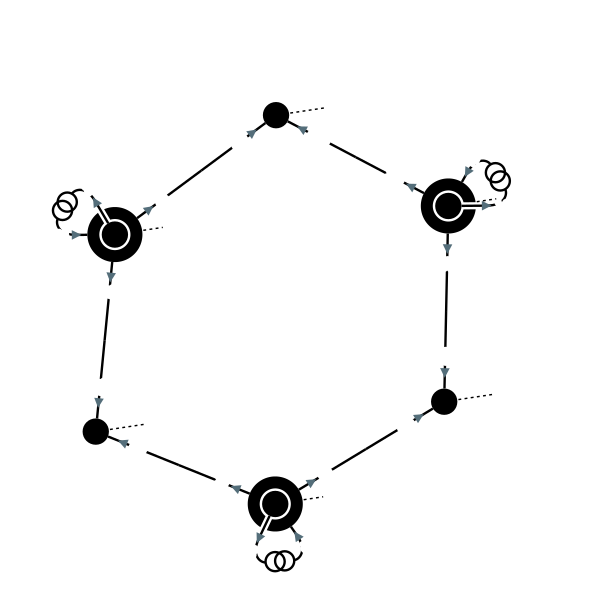

In [35]:
#re-run power flow with updated values
#n2 = pp.network.create_ieee9()
results2=pp.loadflow.run_ac(n2)
pp.loadflow.run_ac(n2)
n2.get_network_area_diagram()

In [36]:
# Print results one item at a time
voltages2=n2.get_buses().v_mag
print(voltages1)
print(voltages2)
#print(voltages.loc['VL1_0'])

id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
id
VL1_0    108.000000
VL1_1    105.773323
VL2_0    102.500000
VL2_1    104.137394
VL3_0    102.500000
VL3_1    104.063950
VL5_0    105.745449
VL6_0    103.699087
VL8_0    102.874990
Name: v_mag, dtype: float64


In [14]:
print(results2[0].slack_bus_results[0].active_power_mismatch)

6.027700139021874e-06


In [55]:
# Adding some load variations:
def create_ieee9_time_series(steps=5, p_set_gen2=163, p_set_gen3=85):
    # Create the IEEE 9-bus network
    network = pp.network.create_ieee9()
    
    # Define time steps
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    
    # Define base loads and variation patterns
    base_loads = {
        'B5-L': {'p': 90, 'q': 30},
        'B6-L': {'p': 100, 'q': 35},
        'B8-L': {'p': 125, 'q': 50}
    }
    
    # Define oscillation patterns similar to PyPSA implementation
    base_patterns = {
        'B5-L': np.array([1, 1, 1, -1, -1]),
        'B6-L': np.array([0, 1, 1, -1, -1]),
        'B8-L': np.array([0, 0, 1, 0, -1])
    }
    
    variation = 0.3  # 30% variation
    
    # Store results for each time step
    results = {}
    load_values = {load_id: {'p': [], 'q': []} for load_id in base_loads.keys()}
    generator_values = {'B1-G': [], 'B2-G': [], 'B3-G': []}
    
    # Set generator values
    network.update_generators(id='B2-G', target_p=p_set_gen2)
    network.update_generators(id='B3-G', target_p=p_set_gen3)
    
    # Create and simulate each time step
    for step in range(min(steps, 5)):
        # Create a variant for this time step
        variant_id = f"step_{step}" # we have used the step_number as variant id
        network.clone_variant('InitialState',variant_id) # network is updated to include this variant...
        network.set_working_variant(variant_id) # here is where the equivalent to "snapshot" in pypsa is set, in powsybl it is called "working_variant"
        
        #with this working variant we can now make some changes to load, or to other grid characteristics
        # Update loads based on patterns
        for load_id, base_load in base_loads.items():
            pattern_value = base_patterns[load_id][step]
            p_value = base_load['p'] * (1 + variation * pattern_value)
            q_value = base_load['q'] * (1 + variation * pattern_value)
            
            network.update_loads(id=load_id, p0=p_value, q0=q_value)
            load_values[load_id]['p'].append(p_value)
            load_values[load_id]['q'].append(q_value)
        
        # Run load flow for this time step
        result = pp.loadflow.run_ac(network)
        results[step] = result
        
        # Get generator output for this time step
        generators = network.get_generators()
        for gen_id in ['B1-G', 'B2-G', 'B3-G']:
            #gen_data = generators[generators['id'] == gen_id]
            gen_data = generators[generators.index == gen_id]
            if not gen_data.empty:
                generator_values[gen_id].append(gen_data['target_p'].values[0])
        
        # Reset to base variant for next iteration
        network.set_working_variant("InitialState")
    
    return network, results, load_values, generator_values, snapshots



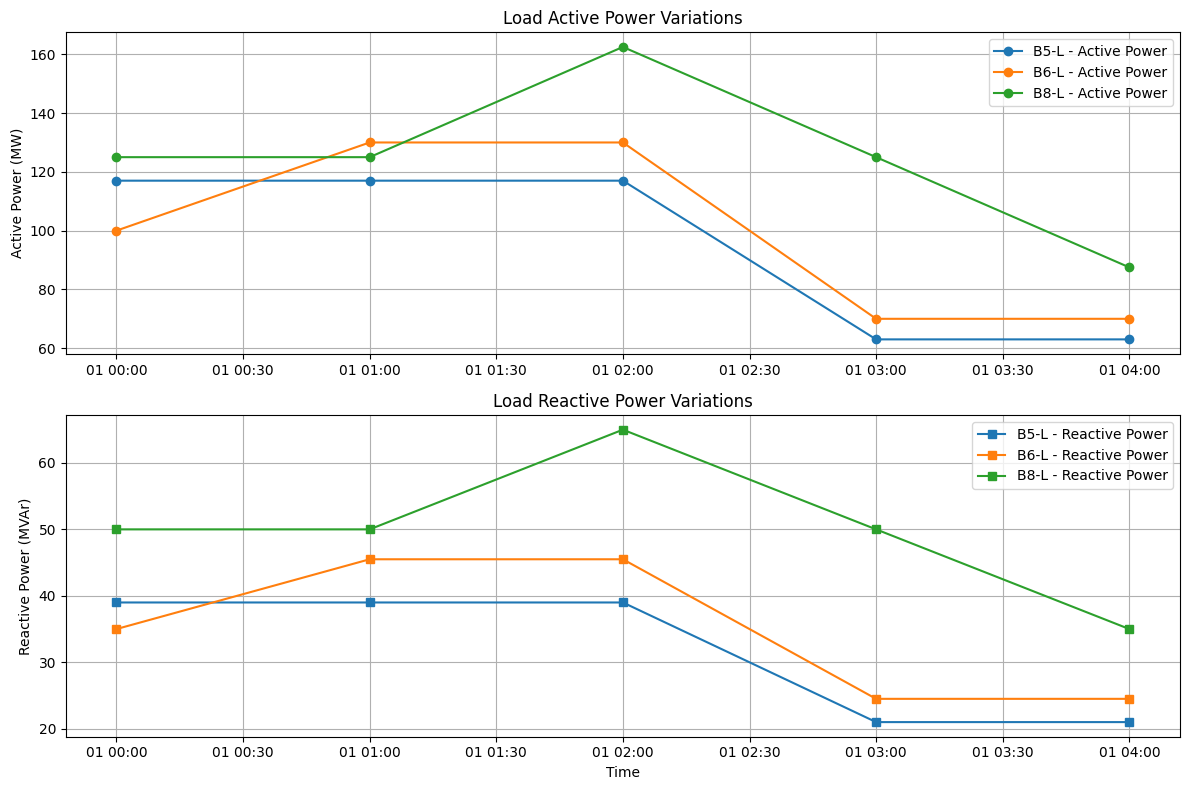

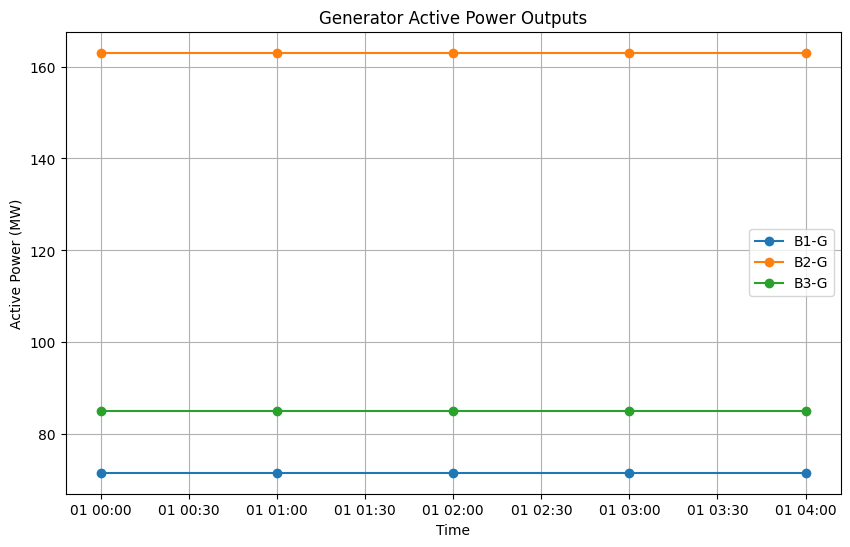

In [60]:
# We can now use the procedure above to create time series simulation
network, results, load_values, generator_values, snapshots = create_ieee9_time_series()

# Plot load variations
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for load_id, values in load_values.items():
    plt.plot(snapshots, values['p'], marker='o', label=f"{load_id} - Active Power")
plt.title('Load Active Power Variations')
plt.ylabel('Active Power (MW)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for load_id, values in load_values.items():
    plt.plot(snapshots, values['q'], marker='s', label=f"{load_id} - Reactive Power")
plt.title('Load Reactive Power Variations')
plt.xlabel('Time')
plt.ylabel('Reactive Power (MVAr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot generator outputs
plt.figure(figsize=(10, 6))
for gen_id, values in generator_values.items():
    plt.plot(snapshots, values, marker='o', label=gen_id)
plt.title('Generator Active Power Outputs')
plt.xlabel('Time')
plt.ylabel('Active Power (MW)')
plt.legend()
plt.grid(True)
plt.show()